**MODEL**

**1.Load Data**

In [7]:
import os
import shutil

# Path folder sumber asli
source_homogenous = os.path.join("RAW_DATA", "picture", "Homogenous", "Homogenous")
source_radial = os.path.join("RAW_DATA", "picture", "Radial Composite")
target_base = "dataset"

# Hapus folder dataset jika sudah ada
if os.path.exists(target_base):
    shutil.rmtree(target_base)
os.makedirs(target_base, exist_ok=True)

# Fungsi salin semua file PNG dari setiap Case
def copy_all_plots(source_dir, target_dir_prefix):
    os.makedirs(target_dir_prefix, exist_ok=True)
    for case in os.listdir(source_dir):
        case_path = os.path.join(source_dir, case)
        if not os.path.isdir(case_path):
            continue

        for fname in os.listdir(case_path):
            if fname.lower().endswith('.png'):
                src_img = os.path.join(case_path, fname)
                fname_clean = fname.replace(' ', '_')
                case_clean = case.replace('#', '').replace(' ', '')
                newname = f"{os.path.basename(target_dir_prefix)}_{case_clean}_{fname_clean}"
                dst_img = os.path.join(target_dir_prefix, newname)
                shutil.copy(src_img, dst_img)

# Proses dua kategori
copy_all_plots(source_homogenous, os.path.join(target_base, "Homogenous"))
copy_all_plots(source_radial, os.path.join(target_base, "Radial_Composite"))

print("Semua file berhasil disalin ke folder 'dataset/' sesuai format.")

Semua file berhasil disalin ke folder 'dataset/' sesuai format.


In [8]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

DATASET_PATH = "dataset"
IMG_SIZE = (224, 224)

def load_image_paths(dataset_path):
    image_paths = []
    labels = []
    label_names = sorted([
        d for d in os.listdir(dataset_path)
        if os.path.isdir(os.path.join(dataset_path, d))
    ])
    label_to_index = {label: idx for idx, label in enumerate(label_names)}

    for label in label_names:
        folder = os.path.join(dataset_path, label)
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                fpath = os.path.join(folder, fname)
                image_paths.append(fpath)
                labels.append(label_to_index[label])

    return image_paths, labels, label_to_index

# Load data dan mapping label
image_paths, labels, label_map = load_image_paths(DATASET_PATH)

print(f"Total gambar: {len(image_paths)}")
print(f"Label map: {label_map}")

Total gambar: 150
Label map: {'Homogenous': 0, 'Radial_Composite': 1}


In [9]:
import random

def make_triplets(image_paths, labels, num_triplets=1000):
    triplets = []
    label_to_paths = {}

    # Kelompokkan gambar berdasarkan label
    for path, label in zip(image_paths, labels):
        label_to_paths.setdefault(label, []).append(path)

    for _ in range(num_triplets):
        anchor_label = random.choice(list(label_to_paths.keys()))
        negative_label = random.choice([l for l in label_to_paths if l != anchor_label])

        anchor = random.choice(label_to_paths[anchor_label])
        positive = random.choice(label_to_paths[anchor_label])
        negative = random.choice(label_to_paths[negative_label])

        triplets.append((anchor, positive, negative))

    return triplets

# Buat triplet
triplets = make_triplets(image_paths, labels, num_triplets=1000)
print(f"Total triplets dibuat: {len(triplets)}")

Total triplets dibuat: 1000


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model

# Perbaikan triplet loss: gunakan axis=1 (karena hasil split shape-nya [None, 128])
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = tf.split(y_pred, num_or_size_splits=3, axis=1)
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss

# Gunakan kembali embedding_model dari Step 4 (jika belum, jalankan build_embedding_model)

# Input 3 gambar
input_anchor = Input(shape=(224, 224, 3), name='anchor_input')
input_positive = Input(shape=(224, 224, 3), name='positive_input')
input_negative = Input(shape=(224, 224, 3), name='negative_input')

# Generate embeddings
encoded_anchor = embedding_model(input_anchor)
encoded_positive = embedding_model(input_positive)
encoded_negative = embedding_model(input_negative)

# Concatenate embeddings jadi satu tensor [None, 128*3]
merged_output = layers.Concatenate(axis=1)([encoded_anchor, encoded_positive, encoded_negative])

# Final Triplet Model
triplet_model = Model(
    inputs=[input_anchor, input_positive, input_negative],
    outputs=merged_output,
    name="TripletModel"
)

# Compile dengan triplet loss yang diperbaiki
triplet_model.compile(optimizer='adam', loss=triplet_loss(margin=1.0))

print("Triplet model successfully compiled.")
triplet_model.summary()


Triplet model successfully compiled.
Model: "TripletModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                

In [18]:
# Lakukan training
history = triplet_model.fit(
    [anchor_imgs, positive_imgs, negative_imgs],
    np.zeros(len(anchor_imgs)),  # dummy label
    batch_size=16,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
57/57 [==============================] - 70s 1s/step - loss: 2.3098 - val_loss: 0.7019
Epoch 2/10
57/57 [==============================] - 49s 856ms/step - loss: 0.4332 - val_loss: 0.4337
Epoch 3/10
57/57 [==============================] - 49s 864ms/step - loss: 0.2482 - val_loss: 0.2702
Epoch 4/10
57/57 [==============================] - 49s 852ms/step - loss: 0.1986 - val_loss: 0.1935
Epoch 5/10
57/57 [==============================] - 47s 829ms/step - loss: 0.1470 - val_loss: 0.1368
Epoch 6/10
57/57 [==============================] - 47s 827ms/step - loss: 0.0914 - val_loss: 0.1253
Epoch 7/10
57/57 [==============================] - 52s 911ms/step - loss: 0.0831 - val_loss: 0.0876
Epoch 8/10
57/57 [==============================] - 51s 889ms/step - loss: 0.0662 - val_loss: 0.0856
Epoch 9/10
57/57 [==============================] - 48s 845ms/step - loss: 0.0473 - val_loss: 0.0807
Epoch 10/10
57/57 [==============================] - 48s 836ms/step - loss: 0.0415 - val_loss:

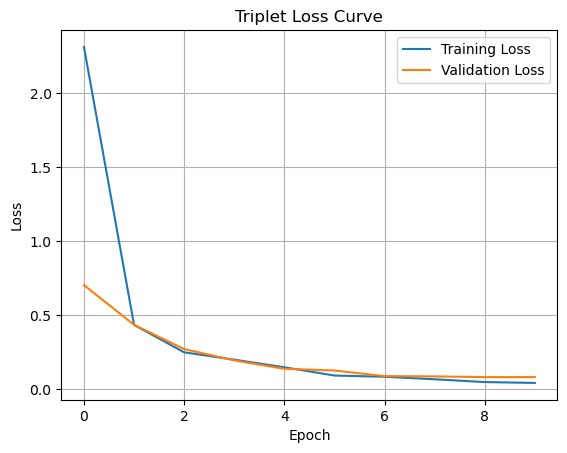

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Triplet Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Ambil semua embedding dan label dari gambar dataset
all_embeddings = []
all_labels = []

for path, label in zip(image_paths, labels):
    img = preprocess_image(path)
    embedding = embedding_model.predict(np.expand_dims(img, axis=0))[0]
    all_embeddings.append(embedding)
    all_labels.append(label)

all_embeddings = np.array(all_embeddings)
all_labels = np.array(all_labels)

1/1 [==============================] - 0s 49ms/step


In [21]:
from sklearn.metrics import accuracy_score

def compute_top_k_accuracy(embeddings, labels, k=3):
    correct = 0
    total = len(embeddings)

    for i in range(total):
        query_emb = embeddings[i]
        query_label = labels[i]

        # Hitung semua jarak ke embedding lain
        distances = np.linalg.norm(embeddings - query_emb, axis=1)

        # Hindari diri sendiri
        distances[i] = np.inf

        # Ambil indeks K terdekat
        top_k_indices = np.argsort(distances)[:k]
        top_k_labels = labels[top_k_indices]

        if query_label in top_k_labels:
            correct += 1

    return correct / total

# Hitung Top-1, Top-3, Top-5 accuracy
top1 = compute_top_k_accuracy(all_embeddings, all_labels, k=1)
top3 = compute_top_k_accuracy(all_embeddings, all_labels, k=3)
top5 = compute_top_k_accuracy(all_embeddings, all_labels, k=5)

print(f"🎯 Top-1 Accuracy: {top1:.2%}")
print(f"🎯 Top-3 Accuracy: {top3:.2%}")
print(f"🎯 Top-5 Accuracy: {top5:.2%}")


🎯 Top-1 Accuracy: 94.67%
🎯 Top-3 Accuracy: 100.00%
🎯 Top-5 Accuracy: 100.00%


In [22]:
# (Ulangi jika perlu)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_names = list(label_map.keys())
label_indices = label_encoder.fit_transform([label_names[i] for i in all_labels])


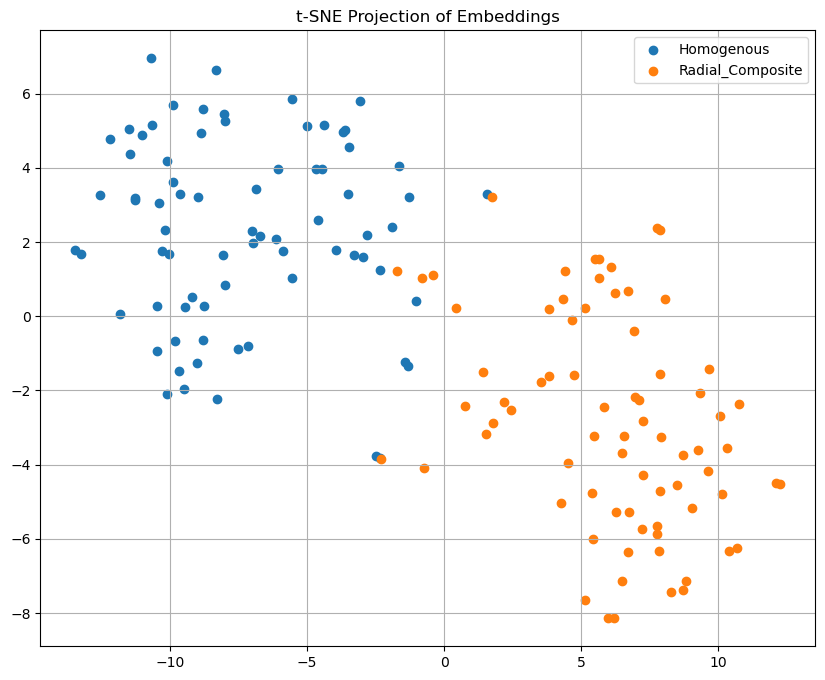

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Jalankan t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(10, 8))
for idx, label in enumerate(np.unique(label_indices)):
    indices = np.where(label_indices == label)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label_names[label])

plt.title("t-SNE Projection of Embeddings")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Simpan embedding model
embedding_model.save("embedding_model.h5")

# Simpan triplet model (jika perlu)
triplet_model.save("triplet_model.h5")

print("Model berhasil disimpan sebagai 'embedding_model.h5' dan 'triplet_model.h5'")


Model berhasil disimpan sebagai 'embedding_model.h5' dan 'triplet_model.h5'


In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

def show_top_k_images(query_path, top_paths):
    k = len(top_paths)
    plt.figure(figsize=(2*(k+1), 4))

    # Tampilkan query
    plt.subplot(1, k+1, 1)
    plt.imshow(load_img(query_path, target_size=(224, 224)))
    plt.title("Query")
    plt.axis('off')

    # Tampilkan hasil Top-K
    for i, path in enumerate(top_paths):
        plt.subplot(1, k+1, i+2)
        plt.imshow(load_img(path, target_size=(224, 224)))
        plt.title(f"Top-{i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Panggil visualisasi
show_top_k_images(query_path, top_paths)


NameError: name 'query_path' is not defined